In [9]:
import numpy as np
from sklearn.decomposition import NMF, PCA
import matplotlib.pyplot as plt
import math
import torch
from scipy.ndimage import rotate


In [10]:
# FOR DELETING BAD DATA SLICES
# for i in range(298):
#     # print(i)
#     if i == 6 or i == 7 or i ==80:
#         intensity_data = np.delete(intensity_data, i, axis=0)
#     # print(intensity_data[i].sum())

# print(intensity_data.shape)

# x = intensity_data
# print(x.shape)

In [11]:
# Import images from .npz files
# Extract data file paths
file_path = "/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/npz_sept_data/npz_field_sweep/"

# TEMP SWEEP MOVIES
# movies = ['121855.npz', '118923.npz', '119486.npz', '119996.npz', '120506.npz', '121016.npz', '121405.npz', '121550.npz', '122365.npz', '122875.npz']

# FIELD SWEEP MOVIES OLD
#movies = ['Field_29mT.npz', 'Field_31mT.npz', 'Field_32mT.npz', 'Field_33mT.npz', 'Field_37mT.npz']

#SEPT DATA
# negative [0-12]
movies = ['neg23mT_553_50mW.npz', 'neg23mT_558_25mW.npz', 'neg25mT_553_50mW.npz', 'neg25mT_558_25mW.npz', 'neg27mT_553_50mW.npz',
          'neg27mT_558_25mW.npz', 'neg29mT_553_50mW.npz', 'neg29mT_558_25mW.npz', 'neg31mT_553_50mW.npz', 'neg31mT_558_25mW.npz',
          'neg33mT_553_50mW.npz', 'neg33mT_558_25mW.npz', 'neg35mT_553_50mW.npz',
# positive [13-24]
          'pos23mT_553_50mW.npz', 'pos23mT_558_25mW.npz', 'pos25mT_553_50mW.npz', 'pos25mT_558_25mW.npz', 'pos27mT_553_50mW.npz',
          'pos27mT_558_25mW.npz', 'pos29mT_553_50mW.npz', 'pos29mT_558_25mW.npz', 'pos31mT_553_50mW.npz', 'pos31mT_558_25mW.npz',
          'pos33mT_553_50mW.npz', 'pos33mT_558_25mW.npz']

# Define the movie you want to run GD and GS on as gif (gif = movies[i])
#movies = ['pos29mT_558_50mW.npz']
gif = movies[14]
print(gif)

movie = np.load(file_path + gif)
intensity_data = movie['data']
# Parameters:
#   iterations: Number of iterations to run the diffusion process.
#   kappa: Threshold for edge stopping (higher means less edge detection).
#   gamma: Step size (controls diffusion speed).
niter=50
kappa=30
gamma=.1
# intensity_data = torch.tensor(anisotropic_diffusion(intensity_data, niter=niter, kappa=kappa, gamma=gamma))
print('Tensor shape should be (X,128,128), where X is the number of images.')
print(intensity_data.shape)


pos23mT_558_25mW.npz
Tensor shape should be (X,128,128), where X is the number of images.
(295, 128, 128)


In [12]:
# Extract data_theta, doesn't matter what image is extracted since we're just getting theta
DATA = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/npz_temp_sweep/image_theta.npz')['data']
# DATA = np.load('/Users/yucongchen/billingegroup/skyrmion_lattices/skyrmion-lattices-data/image_111001.npz')['data']
DATA_THETA = torch.atan2(torch.tensor(DATA[1]), torch.tensor(DATA[0]))
resolution = 10.8 #degrees
offset1 = torch.tensor(0., requires_grad=True)
offset2 = torch.tensor(0., requires_grad=True)

# for the model
MAX_ITER_OFFSET = 101
LR = 1e-2

n_folds = 6
def filter_function(k, theta, n_folds=n_folds):
    filter = torch.exp(k * torch.log((torch.cos(n_folds / 2 * theta))**2))
    return filter

def k_val(fwhm):
    '''fwhm is your resolution given in degrees.

    This is derived based off the assumption that FWHM for the cosine 
    is approximately equal to a gaussian, which is a good assumption for this case
    Because FWHM for the cosine filter is approx equal to FWHM for a gaussian'''
    fwhm = np.deg2rad(fwhm)
    k = np.log(1/2) / (np.log(np.cos(3/2*fwhm)**2))
    return k

k = k_val(resolution)
print('k =', k)

def gradient_descent_optimize_offset(intensity, offset, k=k):
    opt = torch.optim.Adam([offset], lr=LR)
    for i in range(MAX_ITER_OFFSET):
        evaluate_image_theta = filter_function(k, DATA_THETA+offset)
        loss = -(torch.tensor(intensity) * evaluate_image_theta).sum()
        opt.zero_grad()
        loss.backward()
        opt.step()
    return offset.item(), evaluate_image_theta.detach().numpy(), loss

offset_list = []
for i in range(295):
    offset, im, loss = gradient_descent_optimize_offset(intensity_data[i], offset1)
    offset_list.append(offset)

print(len(offset_list))
print(offset_list)


k = 8.553968178278982
295
[-0.16436806321144104, -0.09686688333749771, -0.03689645603299141, -0.11045330762863159, -0.11267030984163284, -0.08391637355089188, -0.12236586213111877, -0.05737655609846115, 0.03260695934295654, -0.09949538111686707, -0.0869273841381073, -0.0416383296251297, -0.04301310330629349, -0.036480147391557693, -0.14516964554786682, -0.08301068842411041, -0.030073149129748344, 0.00570669025182724, 0.10908330976963043, 0.18474972248077393, -0.010953995399177074, 0.053375206887722015, 0.38734638690948486, 0.8462383151054382, 0.8981639742851257, 0.9047211408615112, 0.9317784309387207, 0.974709153175354, 0.968563973903656, 1.074195384979248, 1.1150063276290894, 1.180570363998413, 1.3354132175445557, 1.9679973125457764, 2.0654313564300537, 1.9000871181488037, 2.0236568450927734, 2.1316962242126465, 2.232912302017212, 2.263315439224243, 1.8140206336975098, 1.867618203163147, 1.919411540031433, 1.978995442390442, 2.047157049179077, 2.1853561401367188, 2.3447177410125732, 2

In [13]:
offsets = np.array(offset_list)
offsets_deg = np.rad2deg(offset_list)
# print(offsets_deg)

In [14]:
rotated_intensities = []
for i, im in enumerate(intensity_data):
    rotated_im = rotate(im, offsets_deg[i], reshape=False)
    rotated_intensities.append(rotated_im)

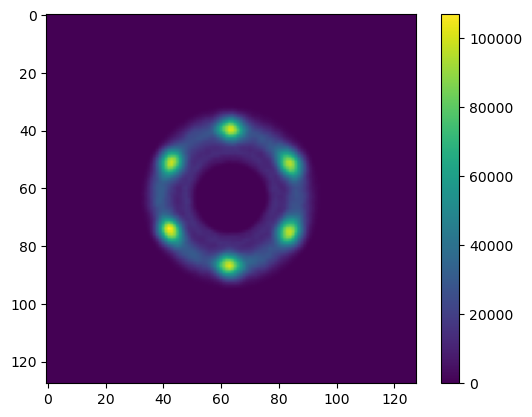

In [15]:
# check to see if peaks overlapped
rotated_ims = np.array(rotated_intensities)
rotated_ims.shape

added_ims = np.zeros_like(rotated_ims[0])
for i, im in enumerate(rotated_ims):
    added_ims += im
    plt.imshow(added_ims)
plt.colorbar()
plt.show()

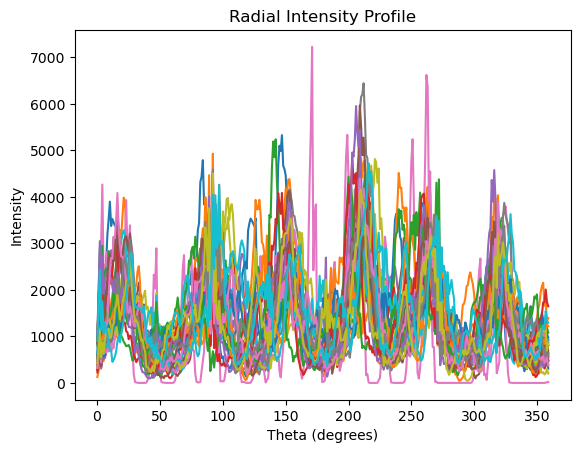

In [16]:
# PLOT THETA VS INTENSITY

def radial_intensity_profile(image, num_bins=360):
    '''creates theta vs. intensity while including rotational variance.'''
    # Define image center
    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
    
    # Create arrays for pixel coordinates
    y, x = np.indices((image.shape))
    x -= center_x
    y -= center_y
    
    # Calculate polar coordinates
    theta = np.arctan2(y, x)  # in radians
    r = np.hypot(x, y)

    # Convert theta to degrees and shift range to [0, 360]
    theta_deg = np.degrees(theta)
    theta_deg = (theta_deg + 360) % 360

    # Bin intensities by angle
    intensity_sum, theta_edges = np.histogram(theta_deg, bins=num_bins, weights=image)
    theta_centers = (theta_edges[1:] + theta_edges[:-1]) / 2

    return theta_centers, intensity_sum

for i in range(30):
    theta, intensity = radial_intensity_profile(intensity_data[i])
    
    # Optional smoothing
    intensity_smoothed = np.convolve(intensity, [0.25, 0.5, 0.75, 1], mode='same')
    
    # Plot the original and smoothed intensity profiles
    plt.plot(theta, intensity_smoothed, label="Smoothed Intensity")

    # plt.plot(theta, intensity, alpha=0.3, label="Original Intensity")
plt.xlabel("Theta (degrees)")
plt.ylabel("Intensity")
plt.title(f"Radial Intensity Profile")
# plt.legend()
plt.show()

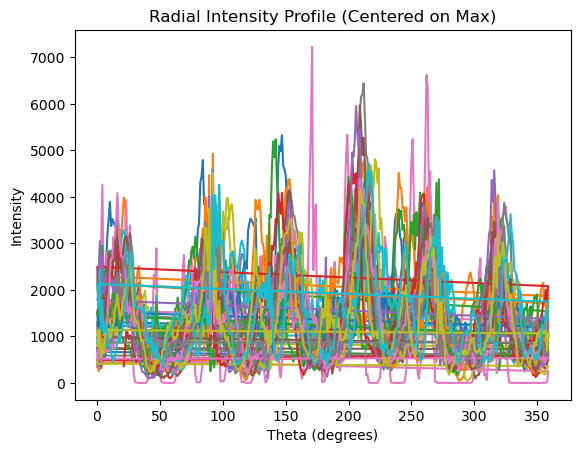

In [17]:
# PLOT THETA VS. INTENSITY CENTERED

def radial_intensity_profile_centered(image, num_bins=360):
    '''This function creates intensity vs. theta while centering the image, removing any rotational variance.'''
    # Define image center
    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
    
    # Create arrays for pixel coordinates
    y, x = np.indices(image.shape)
    x -= center_x
    y -= center_y
    
    # Calculate polar coordinates
    theta = np.arctan2(y, x)  # in radians
    r = np.hypot(x, y)

    # Convert theta to degrees and shift range to [0, 360]
    theta_deg = np.degrees(theta)
    theta_deg = (theta_deg + 360) % 360

    # Bin intensities by angle
    intensity_sum, theta_edges = np.histogram(theta_deg, bins=num_bins, weights=image)
    theta_centers = (theta_edges[1:] + theta_edges[:-1]) / 2

    # Find the index of the maximum intensity to center it
    max_idx = np.argmax(intensity_sum)
    shift_amount = num_bins // 2 - max_idx

    # Circularly shift theta and intensity arrays
    theta_centers = np.roll(theta_centers, shift_amount)
    intensity_sum = np.roll(intensity_sum, shift_amount)

    return theta_centers, intensity_sum

for i in range(30):
    theta, intensity = radial_intensity_profile_centered(intensity_data[i])
    
    # Optional smoothing
    intensity_smoothed = np.convolve(intensity, [0.25, 0.5, 0.75, 1], mode='same')
    
    # Plot the original and smoothed intensity profiles
    plt.plot(theta, intensity_smoothed, label="Smoothed Intensity")

    # plt.plot(theta, intensity, alpha=0.3, label="Original Intensity")
plt.xlabel("Theta (degrees)")
plt.ylabel("Intensity")
plt.title(f"Radial Intensity Profile (Centered on Max)")
plt.show()

In [18]:
# SAVE INT vs THETA PLOTS

int_v_theta = []
for i in range(295):
    theta, int = radial_intensity_profile_centered(intensity_data[i])
    int_conv = np.convolve(int, [.25, .5, .75, 1])
    int_v_theta.append(int_conv)
    # print('convolution shape =', int_conv.shape)
    # plt.plot(int_conv)
    # plt.plot(int, alpha=.2)
    # plt.show()

int_v_theta = np.array(int_v_theta)
print(int_v_theta.shape)

(295, 363)


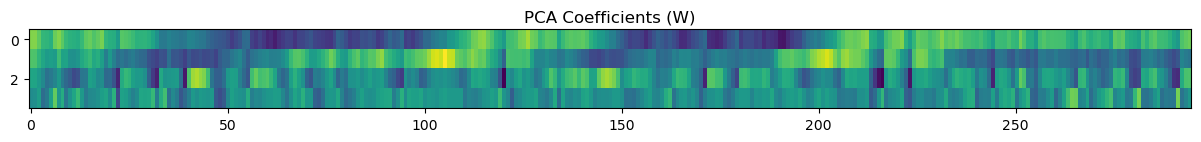

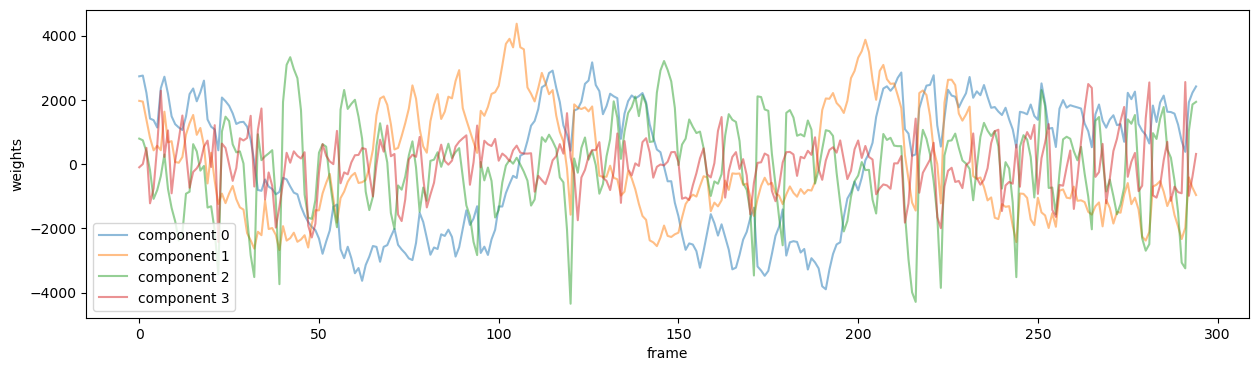

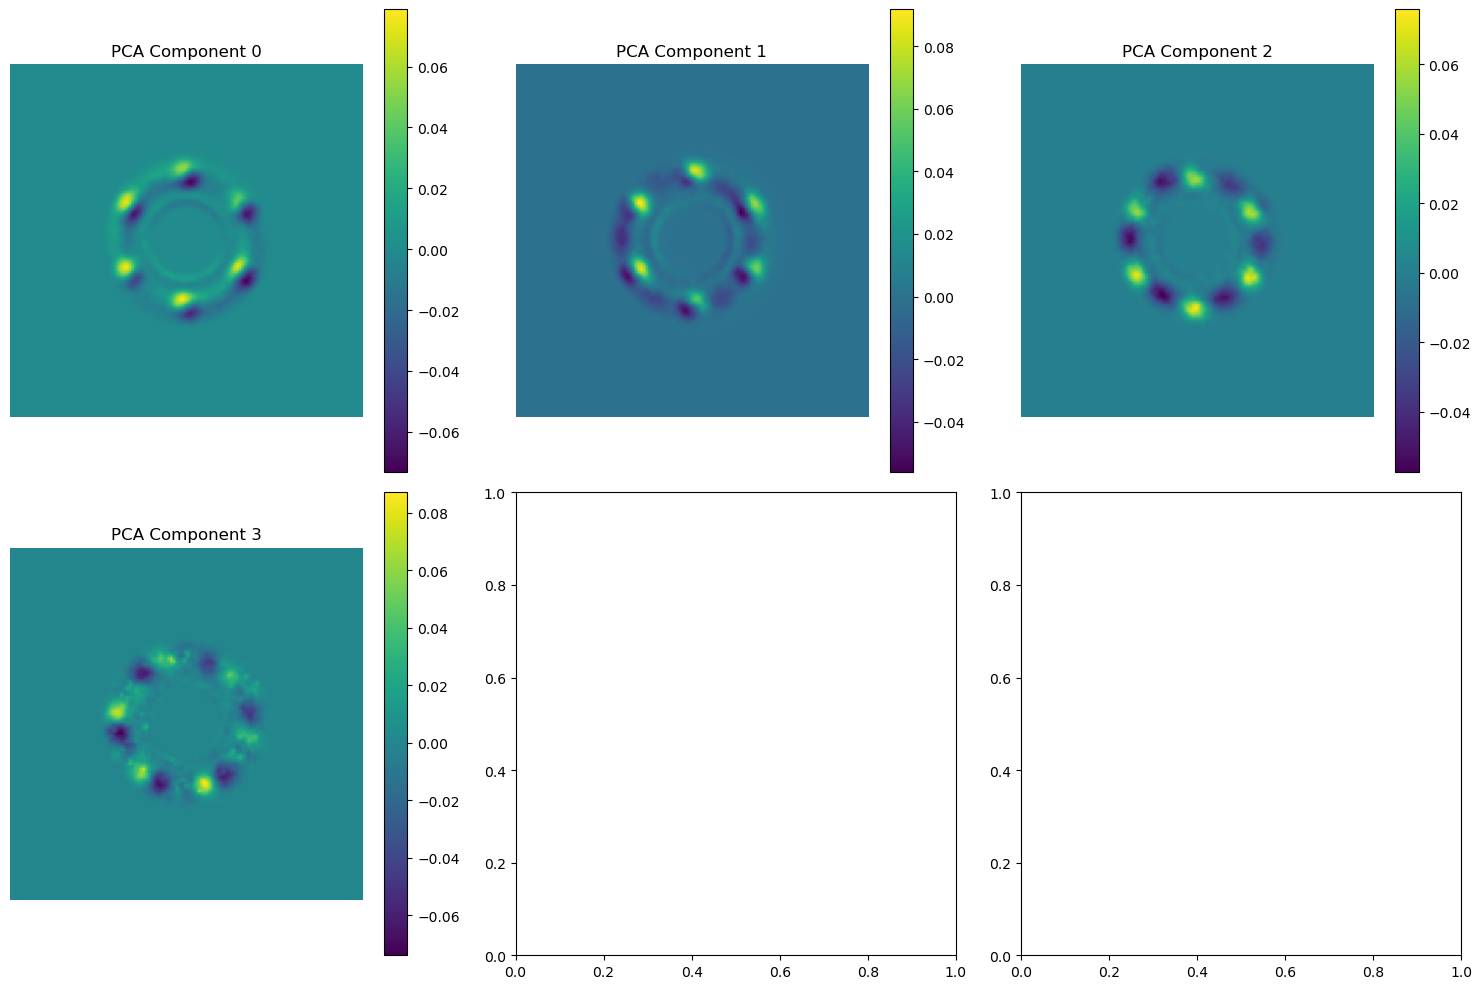

In [19]:
# PCA FUNCTION

def pca_analysis(data, n_components):
    # Check the shape and reshape data for NMF input
    if data.ndim == 3:  # Stack of 2D images
        num_frames, height, width = data.shape
        reshaped_data = data.reshape(num_frames, height * width)
    elif data.ndim == 2:  # 2D data
        reshaped_data = data
    elif data.ndim == 1:  # 1D intensity vs. theta data
        reshaped_data = data.reshape(1, -1)
    else:
        raise ValueError("Data shape not recognized. Must be 1D, 2D, or 3D.")

    # Apply NMF
    nmf = PCA(n_components=n_components, random_state=0) 
    W = nmf.fit_transform(reshaped_data)
    H = nmf.components_

    # Plot coefficients (W matrix)
    plt.figure(figsize=(15, 2))
    plt.imshow(W.T, aspect=5)
    plt.title("PCA Coefficients (W)")
    plt.show()

    # Plot W matrix as lines
    plt.figure(figsize=(15,4))
    for n in range(n_components):
        plt.plot(W.T[n], label= f'component {n}', alpha=.5)

    plt.legend()
    plt.xlabel('frame')
    plt.ylabel('weights')
    plt.show()


    # Set number of columns
    num_cols = 3
    num_rows = math.ceil(H.shape[0] / num_cols)  # Calculate needed rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
    axes = axes.flatten()

    for n, component in enumerate(H):
        if data.ndim == 3:
            pattern = component.reshape(height, width)
            im = axes[n].imshow(pattern, cmap='viridis')
            fig.colorbar(im, ax=axes[n])
            axes[n].axis('off')
        else:
            axes[n].plot(component)
        axes[n].set_title(f'PCA Component {n}')

    plt.tight_layout()
    plt.show()




# pca_analysis(int_v_theta, 4)
pca_analysis(np.abs(rotated_ims), 4)

In [24]:
xrd = np.random.rand(10000, 6)

(363,)
2


/opt/anaconda3/envs/skyrmion/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


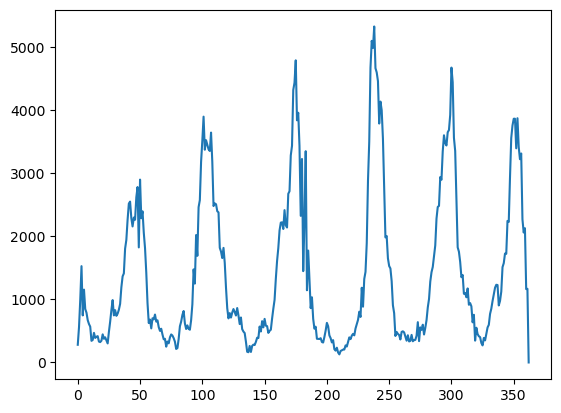

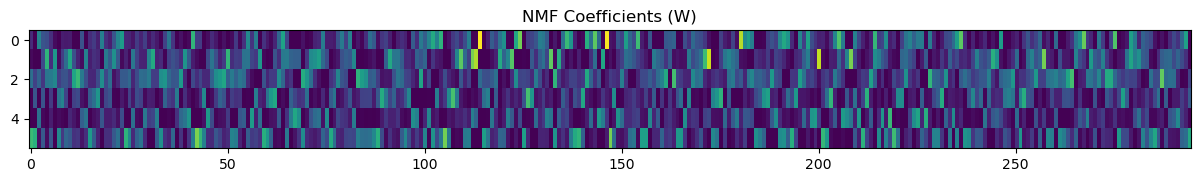

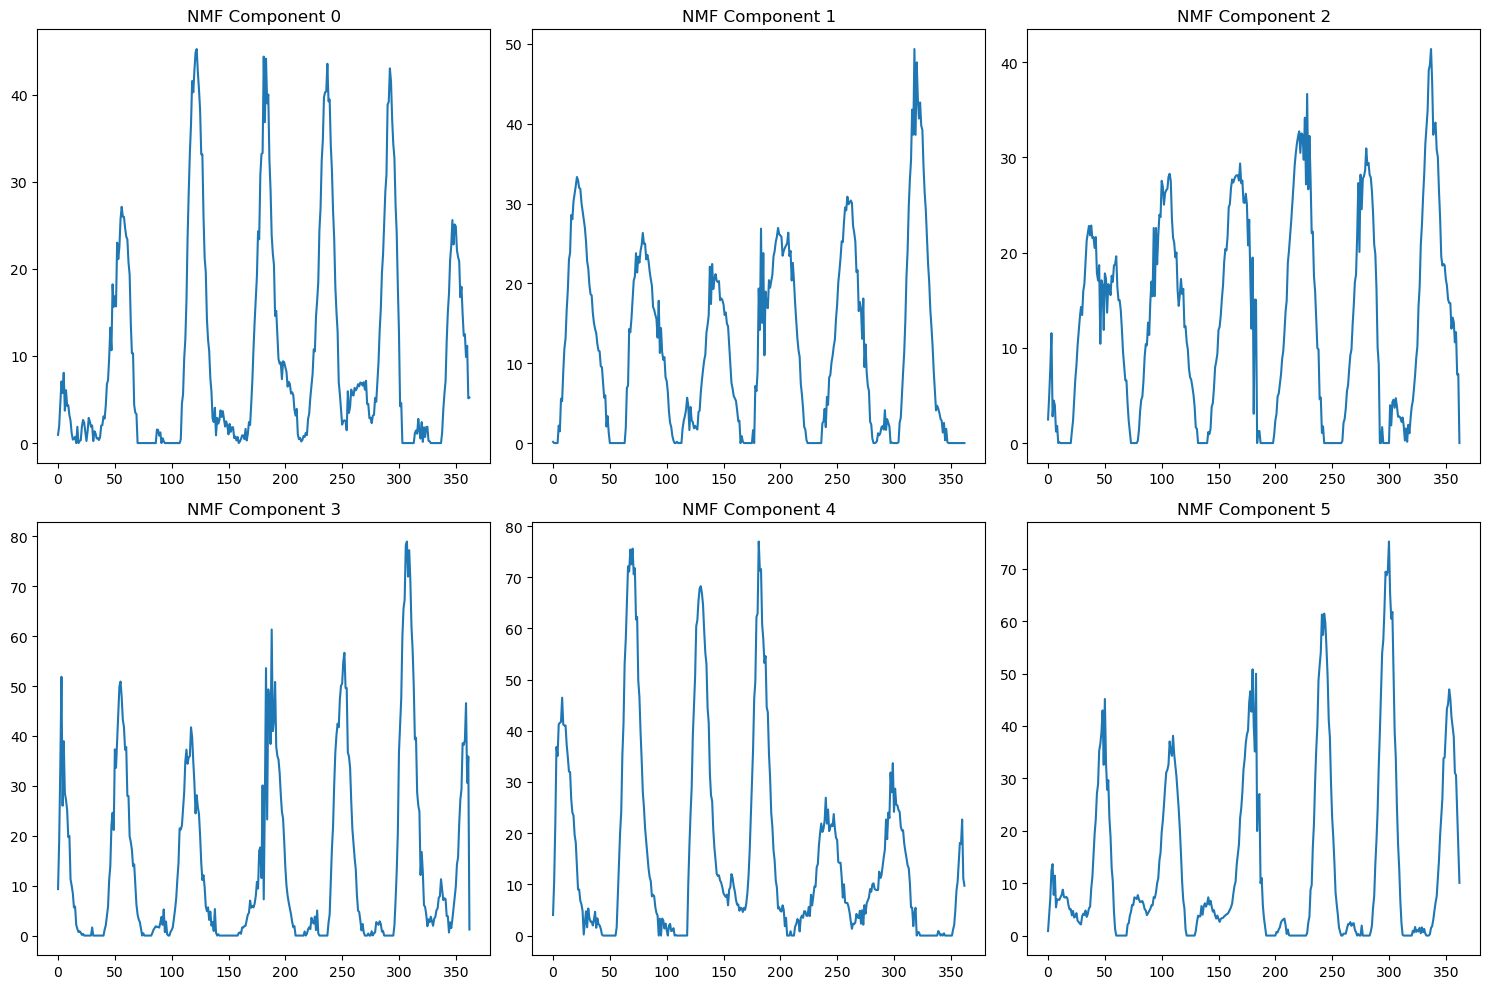

3


/opt/anaconda3/envs/skyrmion/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


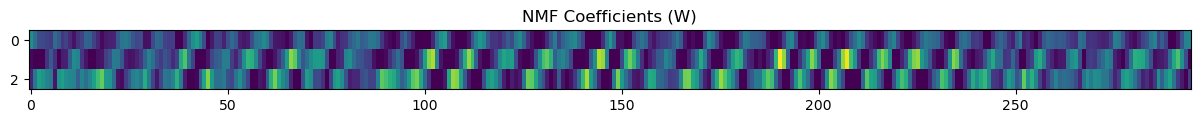

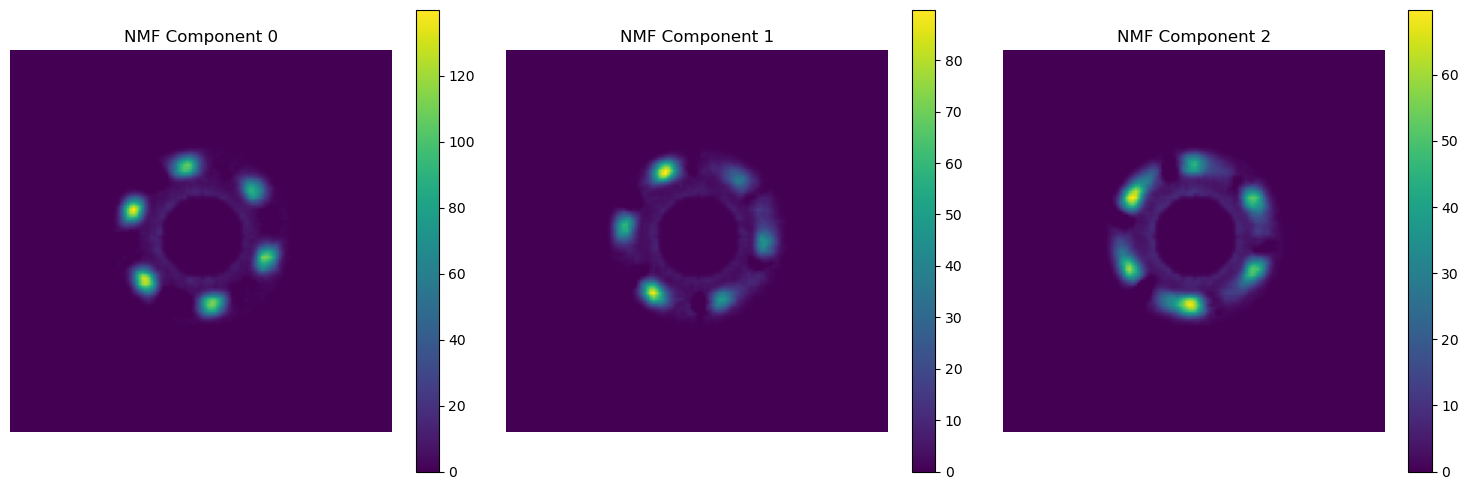

In [32]:
# NMF FUNCTION

def nmf_analysis(data, n_components):
    print(data.ndim)
    # Check the shape and reshape data for NMF input
    if data.ndim == 3:  # Stack of 2D images
        num_frames, height, width = data.shape
        reshaped_data = data.reshape(num_frames, height * width)
    elif data.ndim == 2:  # 2D data
        reshaped_data = data
    elif data.ndim == 1:  # 1D intensity vs. theta data
        reshaped_data = data.reshape(1, -1)
    else:
        raise ValueError("Data shape not recognized. Must be 1D, 2D, or 3D.")

    # Apply NMF
    nmf = NMF(n_components=n_components, init='random', random_state=0) 
    W = nmf.fit_transform(reshaped_data)
    H = nmf.components_

    # Plot coefficients (W matrix)
    plt.figure(figsize=(15, 2))
    plt.imshow(W.T, aspect=5)
    plt.title("NMF Coefficients (W)")
    plt.show()

    # Plot W matrix as lines
    # plt.figure(figsize=(15,4))
    # for n in range(n_components):
    #     plt.plot(W.T[n], label= f'component {n}', alpha=.5)

    # plt.legend()
    # plt.xlabel('frame')
    # plt.ylabel('weights')
    # plt.show()


    # Set number of columns
    num_cols = 3
    num_rows = math.ceil(H.shape[0] / num_cols)  # Calculate needed rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
    axes = axes.flatten()

    for n, component in enumerate(H):
        if data.ndim == 3:
            pattern = component.reshape(height, width)
            im = axes[n].imshow(pattern, cmap='viridis')
            fig.colorbar(im, ax=axes[n])
            axes[n].axis('off')
        else:
            axes[n].plot(component)
        axes[n].set_title(f'NMF Component {n}')

    plt.tight_layout()
    plt.show()



print(int_v_theta[0].shape)
plt.plot(int_v_theta[0])
nmf_analysis(int_v_theta, 6)
nmf_analysis(intensity_data, 3) #np.abs(rotated_ims)